<a href="https://colab.research.google.com/github/Evely90/Co2-Emissions/blob/main/Biggest_predictor_of_CO2_output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Biggest predictor of CO₂ output

In this notebook, the following question will be analyzed:

**What is the biggest predictor of a large CO₂ output per capita of a country?**

To make a thorough analysis, the following question needs to be answered first:

**What are factors that possibly predict large CO₂ output?**

According to [NASA](https://climate.nasa.gov/vital-signs/carbon-dioxide/), [Our World in Data](https://ourworldindata.org/co2-and-greenhouse-gas-emissions) and some scientific studies (linked below), factors that influence CO₂ output could be:
- Energy consumption patterns (electricity from nuclear / renewable sources vs fossil fuels)
- Natural disasters (volcanic eruptions, wildfires)
- Economic growth / GDP / Income
- Urbanization rate
- Technological advancements
- Human capital
- Foreign Direct Investment (FDI)
- Trade activities
- Globalization (economic, social and political)
- Oil production

Of course there could be a lot of other factors that might influence CO₂ output that aren't mentioned in those studies, such as:
- Population density
- Transportation infrastructure (public transport/cars/trucks/aviation)
- Amount of forest/deforestation
- Waste disposal methods
- Amount of livestock
- Meat production/consumption

And possibly more.

So there are a lot of factors to consider. To analyze these factors, good quality data is needed. Also it's needed to narrow it down to not research every factor that might possibly be a predictor. So, for each factor, *Our World in Data* has been consulted to see whether useful data about the factor is available.

This led to the following 10 factors to be included in the analysis:
- Electricity consumption from fossil fuels, nuclear and renewables
- GDP per capita
- Urbanization rate
- Human capital
- Trade activities
- Deforestation
- Oil production
- Aviation
- Transport
- Amount of livestock

*Studies that have been looked at:*
* [Factors affecting CO₂ emissions in China's agriculture sector: A quantile
 regression](https://www.sciencedirect.com/science/article/abs/pii/S136403211830412X)
* [Heterogeneity analysis of factors influencing CO₂ emissions: The role of human capital, urbanization, and FDI](https://www.sciencedirect.com/science/article/abs/pii/S1364032123005014)
* [Factors Affecting CO2 Emissions in the BRICS Countries: A Panel Data Analysis](https://www.sciencedirect.com/science/article/pii/S2212567115008904)
* [Factors affecting CO₂ emission in the Middle East: A panel data analysis](https://www.sciencedirect.com/science/article/abs/pii/S0360544212004422)
* [Impact of globalization, economic factors and energy consumption on CO₂ emissions in Pakistan](https://www.sciencedirect.com/science/article/abs/pii/S0048969719326336)



In [ ]:
# Importing modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy.polynomial.polynomial as poly
from scipy.stats import pearsonr
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Biggest CO₂ output per capita

First let's find out what countries have the biggest CO₂ output per capita.
For this a dataset is used that has the annual CO₂ emissions per capita of a country over different years *(Global Carbon Budget (2023) via [Our World in Data](https://ourworldindata.org/co2-and-greenhouse-gas-emissions))*

In [ ]:
# Import dataframe of CO2 emissions per capita
df = pd.read_csv('https://raw.githubusercontent.com/Evely90/Co2-Emissions/main/co-emissions-per-capita.csv')
df

,Entity,Code,Year,Annual CO₂ emissions (per capita)
0,Afghanistan,AFG,1949,0.001992
1,Afghanistan,AFG,1950,0.011266
2,Afghanistan,AFG,1951,0.012098
3,Afghanistan,AFG,1952,0.011946
4,Afghanistan,AFG,1953,0.013685
...,...,...,...,...
26595,Zimbabwe,ZWE,2018,0.711830
26596,Zimbabwe,ZWE,2019,0.636645
26597,Zimbabwe,ZWE,2020,0.500945
26598,Zimbabwe,ZWE,2021,0.524972


In [ ]:
# Drop unneccessary column
df = df.drop(columns='Code')

# Rename column
df = df.rename(columns={"Entity": "Country", "Annual CO₂ emissions (per capita)": "CO2 Emissions"})

In [ ]:
# Dropping rows that aren't countries
drop_countries = ~df['Country'].isin(['Africa', 'Asia', 'Asia (excl. China and India)', 'Europe', 'Europe (excl. EU-27)',
                             'Europe (excl. EU-28)', 'European Union (27)', 'European Union (28)',
                             'High-income countries', 'Low-income countries', 'Lower-middle-income countries',
                             'North America', 'North America (excl. USA)', 'Oceania', 'South America',
                              'Upper-middle-income countries', 'World'])
df = df[drop_countries]

# Dropping one extremely high value as outlier, to get better graphs
df = df.drop(13076)

# See if there are any null values
df.isnull().sum()

Country          0
Year             0
CO2 Emissions    0
dtype: int64

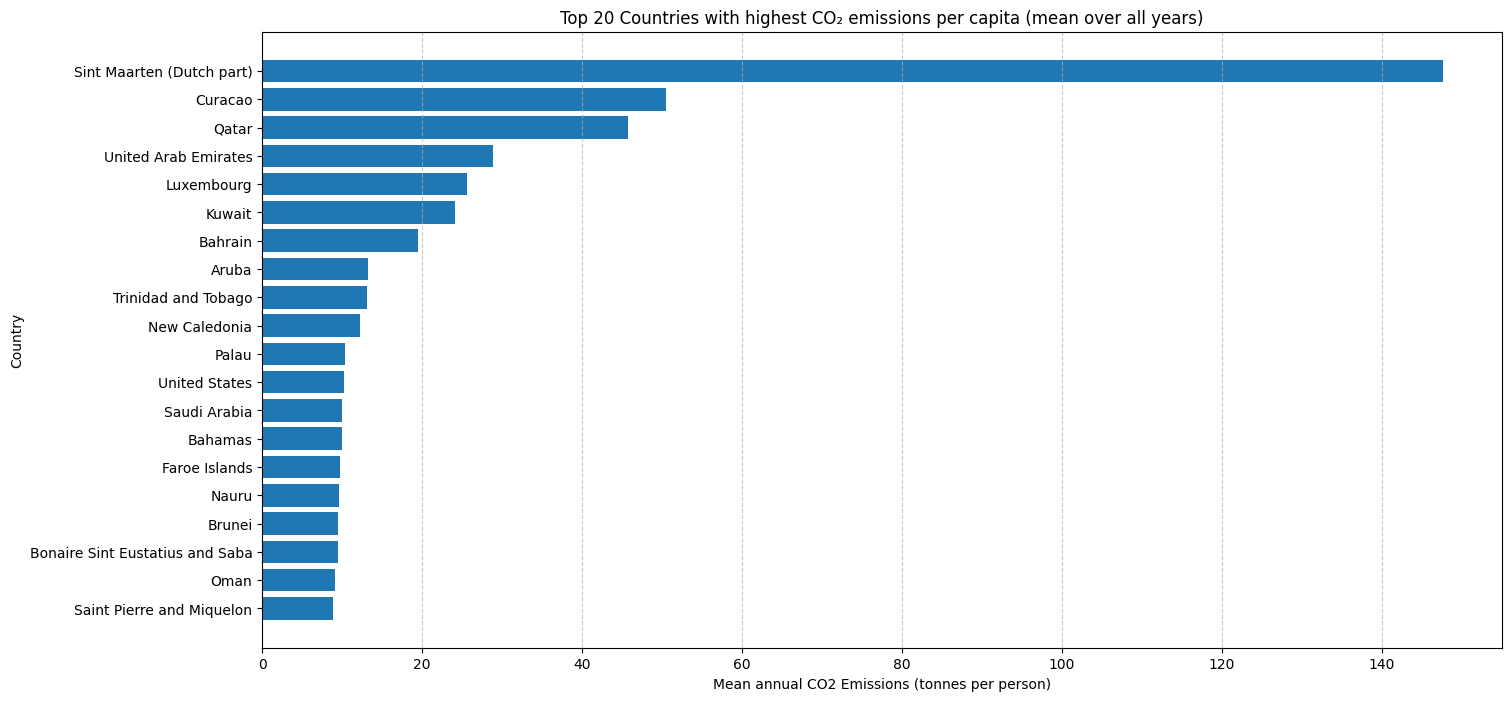

In [ ]:
# Group by country and get the mean CO2 emission across all years for each country
grouped_df = df.groupby('Country')['CO2 Emissions'].mean()
sorted_df = grouped_df.sort_values(ascending=False)

# Select top 10 countries with highest average CO2 emission across all years
top_10 = sorted_df.head(20)
top_10 = top_10[::-1] # Reverse order for better plot

# Plot bar chart
fig, ax = plt.subplots(figsize=(16, 8))
ax.barh(top_10.index, top_10.values)

# Add labels and title
plt.xlabel("Mean annual CO2 Emissions (tonnes per person)")
plt.ylabel("Country")
plt.title("Top 20 Countries with highest CO₂ emissions per capita (mean over all years)")

# Add horizontal grid lines
ax.grid(True, axis="x", linestyle='--', alpha=0.7)

plt.show()

# Creation of functions

In [ ]:
# Function to create scatterplots for each factor
def make_scatterplot(df, cols_x, cols_y, xlabel, ylabel, title, legend_titles=None, decimals=None):
    fig, ax = plt.subplots(figsize=(14, 8))

    # Set colors of points and regression line
    point_colors = sns.color_palette('Set2')
    line_colors = sns.color_palette('Dark2')

    for i, col_y in enumerate(cols_y):
        for j, col_x in enumerate(cols_x):
            x = df[col_x]
            y = df[col_y]

            label = col_x if legend_titles is None else legend_titles[col_x]
            plt.scatter(x, y, label=label, alpha=0.4, color=point_colors[j])

            # Add linear regression
            try:
                coefs = np.polyfit(x, y, 1)
                poly_line = np.poly1d(coefs)
                legend_label = f'{label} (Linear Regression: {coefs[0]:.5f}x + {coefs[1]:.2f})'
                plt.plot(x, poly_line(x), label=legend_label, color=line_colors[j])
            except ValueError as error:
                print(f"Could not plot linear regression line because: {error}")

    def format_x_axis(x, _): # Format x-axis labels
      if decimals is not None:
          return '{:,.{}f}'.format(x, decimals).replace(',', '.')
      else:
          return '{:,.2f}'.format(x).replace(',', '.')

    ax.xaxis.set_major_formatter(FuncFormatter(format_x_axis))

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(linestyle='--', alpha=0.7)
    plt.show()

In [ ]:
# Function to calculate correlation and p-value
def calc_correlation(df, col1, col2):
    # Calculate correlation coefficient and p-value with pearsonr
    corr_coefficient, p_value = pearsonr(df[col1], df[col2])

    # Calculate correlation using pandas corr method
    corr_df = df[[col1, col2]].corr(numeric_only=True).iloc[0, 1]

    # Print the results
    print("Correlation between", col1, "and", col2, ":")
    print("Correlation with pearsonr = ", corr_coefficient, " with a p-value of ", p_value)
    print("Correlation with corr method = ", corr_df, '\n')

# Factor 1: Electricity consumption from fossil fuels, nuclear and renewables
For this factor a dataset is used that has data of the total electricity consumption from fossil fuels, nuclear and renewables for all countries in different years, measured in TWh (Terawatt hours) *(Ember - Yearly Electricity Data (2023); Ember - European Electricity Review (2022); Energy Institute - Statistical Review of World Energy (2023) via [Our World in Data](https://ourworldindata.org/grapher/elec-mix-bar?tab=table)).*

In [ ]:
electricity = pd.read_csv('https://raw.githubusercontent.com/Evely90/Co2-Emissions/main/elec-mix-bar%20(1).csv')

# Drop unneccessary column
electricity = electricity.drop(columns='Code')

# Rename columns
electricity = electricity.rename(columns={"Electricity from fossil fuels - TWh (adapted for visualization of chart elec-mix-bar)": "Fossil Fuels (TWh)",
                        "Electricity from nuclear - TWh (adapted for visualization of chart elec-mix-bar)": "Nuclear (TWh)",
                        "Electricity from renewables - TWh (adapted for visualization of chart elec-mix-bar)": "Renewables (TWh)",
                        "Entity": "Country"})

# Merge dataframes
df_electricity = pd.merge(df, electricity, on=["Country", "Year"])
df_electricity

,Country,Year,CO2 Emissions,Fossil Fuels (TWh),Nuclear (TWh),Renewables (TWh)
0,Afghanistan,2000,0.053581,0.16,0.0,0.31
1,Afghanistan,2001,0.054300,0.09,0.0,0.50
2,Afghanistan,2002,0.063856,0.13,0.0,0.56
3,Afghanistan,2003,0.068871,0.31,0.0,0.63
4,Afghanistan,2004,0.052529,0.33,0.0,0.56
...,...,...,...,...,...,...
5175,Zimbabwe,2017,0.630165,3.05,0.0,4.30
5176,Zimbabwe,2018,0.711830,3.73,0.0,5.46
5177,Zimbabwe,2019,0.636645,3.66,0.0,4.58
5178,Zimbabwe,2020,0.500945,3.40,0.0,4.19


In [ ]:
# Check for null values
df_electricity.isnull().sum()

Country               0
Year                  0
CO2 Emissions         0
Fossil Fuels (TWh)    0
Nuclear (TWh)         0
Renewables (TWh)      0
dtype: int64

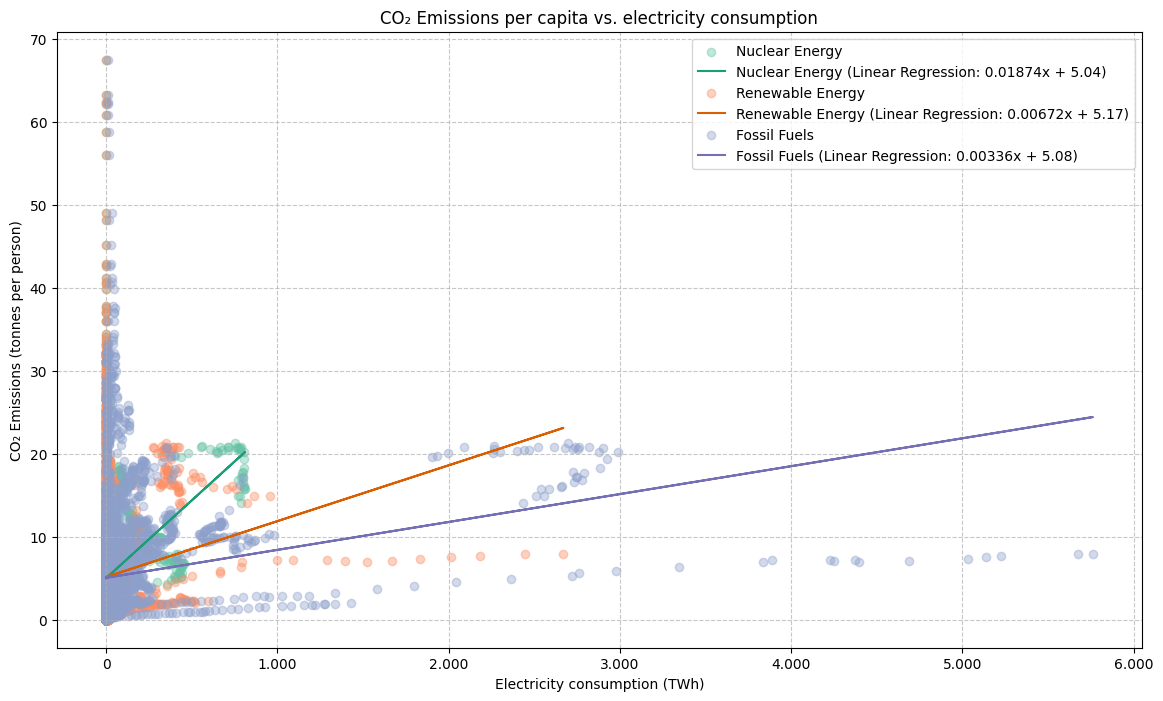

In [ ]:
# Create scatterplot with regression line
make_scatterplot(df_electricity, ['Nuclear (TWh)', 'Renewables (TWh)', 'Fossil Fuels (TWh)'],
                 ['CO2 Emissions'],
                 xlabel="Electricity consumption (TWh)",
                 ylabel="CO₂ Emissions (tonnes per person)",
                 title="CO₂ Emissions per capita vs. electricity consumption",
                 legend_titles={'Nuclear (TWh)': 'Nuclear Energy', 'Renewables (TWh)': 'Renewable Energy', 'Fossil Fuels (TWh)': 'Fossil Fuels'},
                 decimals=0)

In [ ]:
# Calculate correlation
calc_correlation(df_electricity, 'Nuclear (TWh)', 'CO2 Emissions')
calc_correlation(df_electricity, 'Renewables (TWh)', 'CO2 Emissions')
calc_correlation(df_electricity, 'Fossil Fuels (TWh)', 'CO2 Emissions')

Correlation between Nuclear (TWh) and CO2 Emissions :
Correlation with pearsonr =  0.2234077821028511  with a p-value of  1.3361674802523308e-59
Correlation with corr method =  0.22340778210285098 

Correlation between Renewables (TWh) and CO2 Emissions :
Correlation with pearsonr =  0.11404915737270509  with a p-value of  1.8217803622730247e-16
Correlation with corr method =  0.11404915737270536 

Correlation between Fossil Fuels (TWh) and CO2 Emissions :
Correlation with pearsonr =  0.18427662262923247  with a p-value of  8.547268143656565e-41
Correlation with corr method =  0.18427662262923278 



The chart shows that regardless of the source of electricity consumption (nuclear, renewable, or fossil fuels), there will always be a base level of around 5 tonnes of CO₂ emissions per capita of a country.
* For each TWh increase in nuclear electricity consumption, the CO₂ emission per person will increase with 0.019.
* For each TWh increase in renewable electricity consumption, the CO₂ emission per person will increase with 0.007.
* For each TWh increase in fossil fuel electricity consumption, the CO₂ emission per person will increase with 0.003.

It's interesting that the CO₂ emissions per person will raise quicker through the use of nuclear or renewable energy than through the use of fossil fuel electricity. Possibly there are other factors influencing this small raise in CO₂ emissions. One example, the manufacturing or storage of nuclear or renewable energy might cause extra CO₂ emissions. The graph shows at least that when renewable or nuclear energy is used, the yearly electricity consumption in TWh is on average a lot lower than when fossil fuels are used.

The correlation coefficients show a positive but very weak significant correlation between the different sources of electricity consumption and CO₂ emissions per capita of a country.

These different forms of electricity consumption don't seem to be big predictors of CO₂ emissions.

# Factor 2: GDP per capita
For this factor a dataset is used that has data of the GDP per capita for all countries in different years. The data is adjusted for inflation and for differences in the cost of living between countries. *(World Bank (2023) via [Our World in Data](https://ourworldindata.org/grapher/gdp-per-capita-worldbank)).*

In [ ]:
gdp = pd.read_csv('https://raw.githubusercontent.com/Evely90/Co2-Emissions/main/gdp-per-capita-worldbank.csv')

# Drop unneccessary column
gdp = gdp.drop(columns='Code')

# Rename column
gdp = gdp.rename(columns={"Entity": "Country", "GDP per capita, PPP (constant 2017 international $)": "GDP per capita"})

# Merge dataframes
df_gdp = pd.merge(df, gdp, on=["Country", "Year"])
df_gdp

,Country,Year,CO2 Emissions,GDP per capita
0,Afghanistan,2002,0.063856,1280.4631
1,Afghanistan,2003,0.068871,1292.3335
2,Afghanistan,2004,0.052529,1260.0605
3,Afghanistan,2005,0.077403,1352.3207
4,Afghanistan,2006,0.084869,1366.9932
...,...,...,...,...
5817,Zimbabwe,2017,0.630165,2331.7808
5818,Zimbabwe,2018,0.711830,2399.6216
5819,Zimbabwe,2019,0.636645,2203.3967
5820,Zimbabwe,2020,0.500945,1990.3195


In [ ]:
# Check for null values
df_gdp.isnull().sum()

Country           0
Year              0
CO2 Emissions     0
GDP per capita    0
dtype: int64

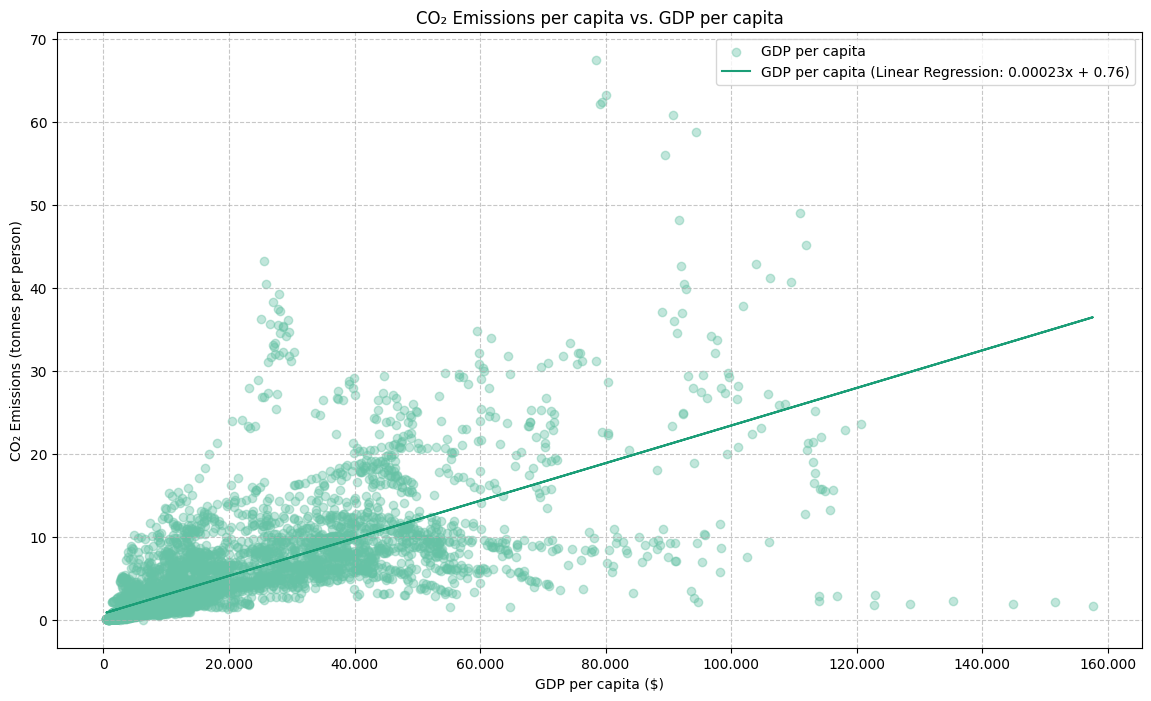

In [ ]:
# Create scatterplot with regression line
make_scatterplot(df_gdp, ['GDP per capita'],
                 ['CO2 Emissions'],
                 xlabel="GDP per capita ($)",
                 ylabel="CO₂ Emissions (tonnes per person)",
                 title="CO₂ Emissions per capita vs. GDP per capita",
                 decimals=0)

In [ ]:
# Calculate correlation
calc_correlation(df_gdp, 'GDP per capita', 'CO2 Emissions')

Correlation between GDP per capita and CO2 Emissions :
Correlation with pearsonr =  0.7086393616926895  with a p-value of  0.0
Correlation with corr method =  0.7086393616926893 



The chart shows that if the GDP per capita is 0, there is a baseline of 0.76 tonnes of CO₂ emissions on average per capita of a country.
The CO₂ emissions per head of capita raises with 2.3 tonnes per person for each $10.000 raise in GDP per capita. This raise is a significant relationship because the correlation is 0.7 which indicates there is a strong positive linear relation between GDP per capita and CO₂ emissions per capita. So GDP per capita is a predictor of CO₂ output.

# Factor 3: Urbanization rate
What exactly is 'Urbanization'? Urbanizaton is the ratio of people that live in urban areas instead of rural areas. The definition of what an 'urban area' exactly is, differs per country and is based on national definitions. ([Our World in Data](https://ourworldindata.org/urbanization)). Urbanization might lead to higher CO₂ emissions because in urbanized areas there might be more energy consumption, transportation and industrial activity. For this factor a dataset is used that has data on the percentage of urbanization for each country in different years. *(UN Population Division (via World Bank) via [Our World in Data](https://ourworldindata.org/grapher/share-of-population-urban))*.

In [ ]:
urban = pd.read_csv('https://raw.githubusercontent.com/Evely90/Co2-Emissions/main/share-of-population-urban.csv')

# Drop unneccessary column
urban = urban.drop(columns='Code')

# Rename column
urban = urban.rename(columns={"Entity": "Country", "Urban population (% of total population)": "Urban population (%)"})

# Merge dataframes
df_urban = pd.merge(df, urban, on=["Country", "Year"])
df_urban

,Country,Year,CO2 Emissions,Urban population (%)
0,Afghanistan,1960,0.048001,8.401
1,Afghanistan,1961,0.055835,8.684
2,Afghanistan,1962,0.076774,8.976
3,Afghanistan,1963,0.077176,9.276
4,Afghanistan,1964,0.089632,9.586
...,...,...,...,...
12268,Zimbabwe,2017,0.630165,32.237
12269,Zimbabwe,2018,0.711830,32.209
12270,Zimbabwe,2019,0.636645,32.210
12271,Zimbabwe,2020,0.500945,32.242


In [ ]:
# Check for null values
df_urban.isnull().sum()

Country                 0
Year                    0
CO2 Emissions           0
Urban population (%)    0
dtype: int64

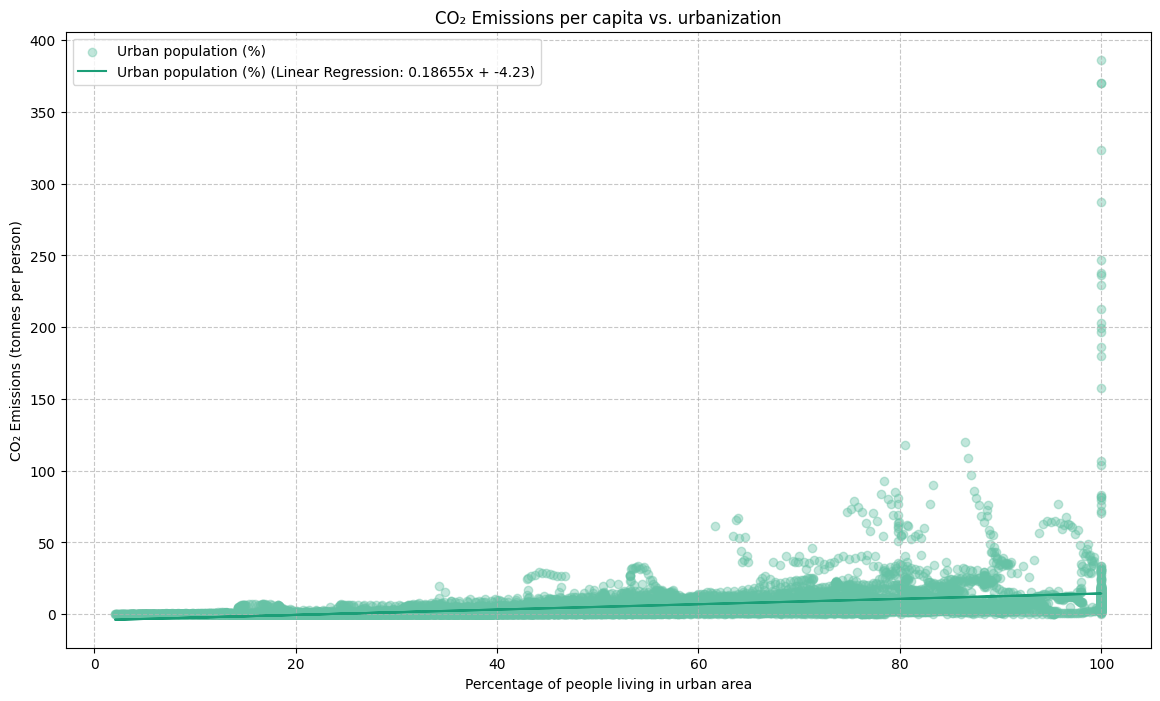

In [ ]:
# Create scatterplot with regression line
make_scatterplot(df_urban, ['Urban population (%)'],
                 ['CO2 Emissions'],
                 xlabel="Percentage of people living in urban area",
                 ylabel="CO₂ Emissions (tonnes per person)",
                 title="CO₂ Emissions per capita vs. urbanization",
                 decimals=0)

In [ ]:
# Calculate correlation
calc_correlation(df_urban, 'Urban population (%)', 'CO2 Emissions')

Correlation between Urban population (%) and CO2 Emissions :
Correlation with pearsonr =  0.3768430171910089  with a p-value of  0.0
Correlation with corr method =  0.3768430171910062 



The chart shows that, for every extra percent of people of a country living in an urban area, the CO₂ emission will increase with 0.19 tonnes per capita of a country. There is a moderate significant correlation (0.37) between CO₂ emissions of a country and its percentage of people living in an urban area.


# Factor 4: Human capital
What exactly is 'Human capital'? Human capital, according to [Our World in Data](https://ourworldindata.org/grapher/human-capital-index-in-2018):

> "The Human Capital Index (HCI) combines indicators of health and education into a measure of the human capital that a child born today can expect to obtain by their 18th birthday, on a scale from 0 to 1. Higher values indicate higher expected human capital."

The dataset used for this factor has the HCI on a scale from 0 to 1 for each country for different years *(World Bank via [Our World in Data](https://ourworldindata.org/grapher/human-capital-index-in-2018))*. The dataset is smaller than for the other factors, a lot of data from certain years and countries are missing, so that needs to be taken into account when drawing conclusions from it.

In [ ]:
hci = pd.read_csv('https://raw.githubusercontent.com/Evely90/Co2-Emissions/main/human-capital-index-in-2018.csv')

# Drop unneccessary column
hci = hci.drop(columns=['Code', 'Continent'])

# Rename columns
hci = hci.rename(columns={"Entity": "Country", "Human capital index (HCI) (scale 0-1)": "HCI"})

# Merge dataframes
df_hci = pd.merge(df, hci, on=["Country", "Year"])
df_hci

,Country,Year,CO2 Emissions,HCI
0,Afghanistan,2015,0.290076,NaN
1,Afghanistan,2017,0.276853,0.389000
2,Afghanistan,2018,0.294876,0.393489
3,Afghanistan,2020,0.305039,0.400284
4,Albania,2010,1.642020,0.543603
...,...,...,...,...
810,Zimbabwe,2010,0.681789,0.410366
811,Zimbabwe,2015,0.865772,NaN
812,Zimbabwe,2017,0.630165,0.441000
813,Zimbabwe,2018,0.711830,0.461242


In [ ]:
# Check for null values
df_hci.isnull().sum()

Country            0
Year               0
CO2 Emissions      0
HCI              214
dtype: int64

In [ ]:
# Dropping null values
df_hci = df_hci.dropna()
df_hci.isnull().sum()

Country          0
Year             0
CO2 Emissions    0
HCI              0
dtype: int64

In [ ]:
# Display to view how many data is left. Only 601 rows, that's not a lot.
display(df_hci)

,Country,Year,CO2 Emissions,HCI
1,Afghanistan,2017,0.276853,0.389000
2,Afghanistan,2018,0.294876,0.393489
3,Afghanistan,2020,0.305039,0.400284
4,Albania,2010,1.642020,0.543603
6,Albania,2017,1.838272,0.621000
...,...,...,...,...
809,Zambia,2020,0.430287,0.396928
810,Zimbabwe,2010,0.681789,0.410366
812,Zimbabwe,2017,0.630165,0.441000
813,Zimbabwe,2018,0.711830,0.461242


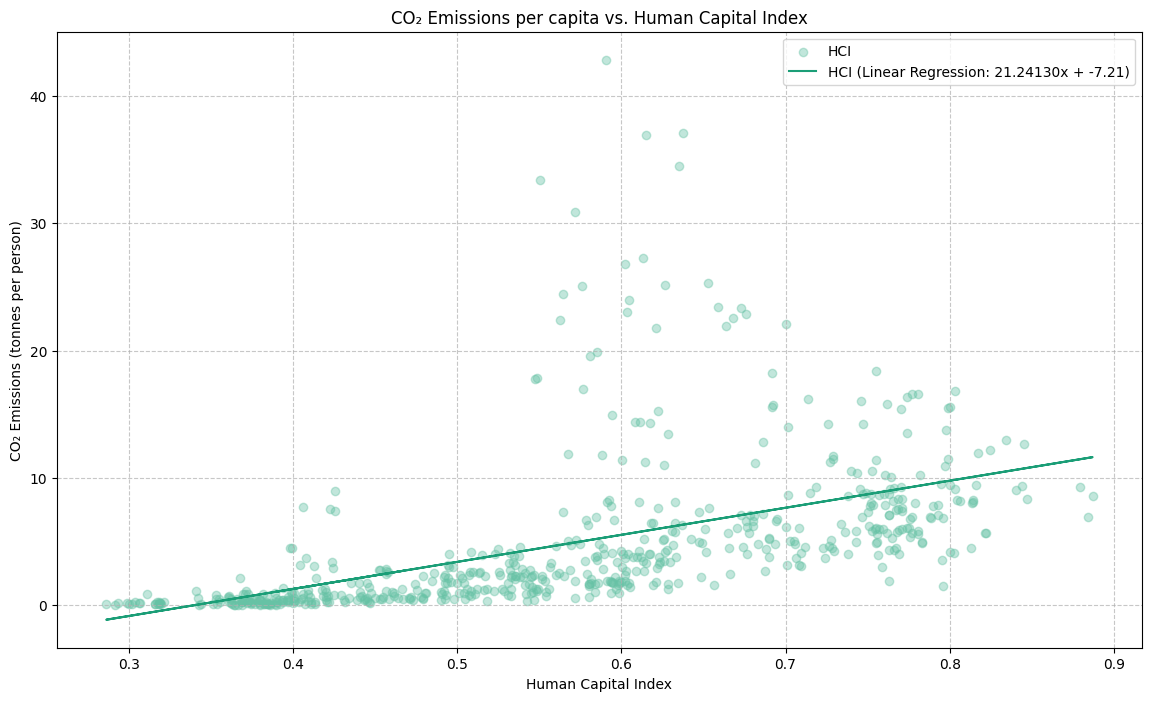

In [ ]:
# Create scatterplot with regression line
make_scatterplot(df_hci, ['HCI'],
                 ['CO2 Emissions'],
                 xlabel="Human Capital Index",
                 ylabel="CO₂ Emissions (tonnes per person)",
                 title="CO₂ Emissions per capita vs. Human Capital Index",
                 decimals=1)

In [ ]:
# Calculate correlation
calc_correlation(df_hci, 'HCI', 'CO2 Emissions')

Correlation between HCI and CO2 Emissions :
Correlation with pearsonr =  0.5110462544811931  with a p-value of  2.703661887718955e-41
Correlation with corr method =  0.5110462544811933 



The graph shows the Human Capital Index (HCI) has some influence on the CO₂ emissions per capita of a country. When the HCI gets 0.1 higher, the CO₂ emission per capita of a country raises with 2.1 tonnes.
The correlation supports there is a relation between HCI and CO₂ emissions with a significant correlation of 0.5.
However, this dataset has a lot less data than the datasets of the other factors, so that might bias the results. However, if this would be supported by a larger amount of data, HCI could be a predictor of CO₂ emissions.

# Factor 5: Trade activities
The dataset used for this factor is a dataset that shows the 'Trade Openness Index'. According to [Our World in Data](https://ourworldindata.org/grapher/trade-as-share-of-gdp), this is:

> "Trade as a share of GDP: Sum of exports and imports of goods and services, divided by gross domestic product, expressed as a percentage."

The dataset shows a column with this percentage. *(World Bank and OECD via [Our World in Data](https://ourworldindata.org/grapher/human-capital-index-in-2018))*

In [ ]:
trade = pd.read_csv('https://raw.githubusercontent.com/Evely90/Co2-Emissions/main/trade-as-share-of-gdp.csv')

# Drop unneccessary column
trade = trade.drop(columns=['Code'])

# Rename columns
trade = trade.rename(columns={"Entity": "Country"})

# Merge dataframes
df_trade = pd.merge(df, trade, on=["Country", "Year"])
df_trade

,Country,Year,CO2 Emissions,Trade (% of GDP)
0,Afghanistan,1960,0.048001,11.157026
1,Afghanistan,1961,0.055835,12.550610
2,Afghanistan,1962,0.076774,14.227644
3,Afghanistan,1963,0.077176,26.035511
4,Afghanistan,1964,0.089632,26.944448
...,...,...,...,...
8346,Zimbabwe,2017,0.630165,50.029713
8347,Zimbabwe,2018,0.711830,54.550270
8348,Zimbabwe,2019,0.636645,52.687570
8349,Zimbabwe,2020,0.500945,54.650562


In [ ]:
# Check for null values
df_trade.isnull().sum()

Country             0
Year                0
CO2 Emissions       0
Trade (% of GDP)    0
dtype: int64

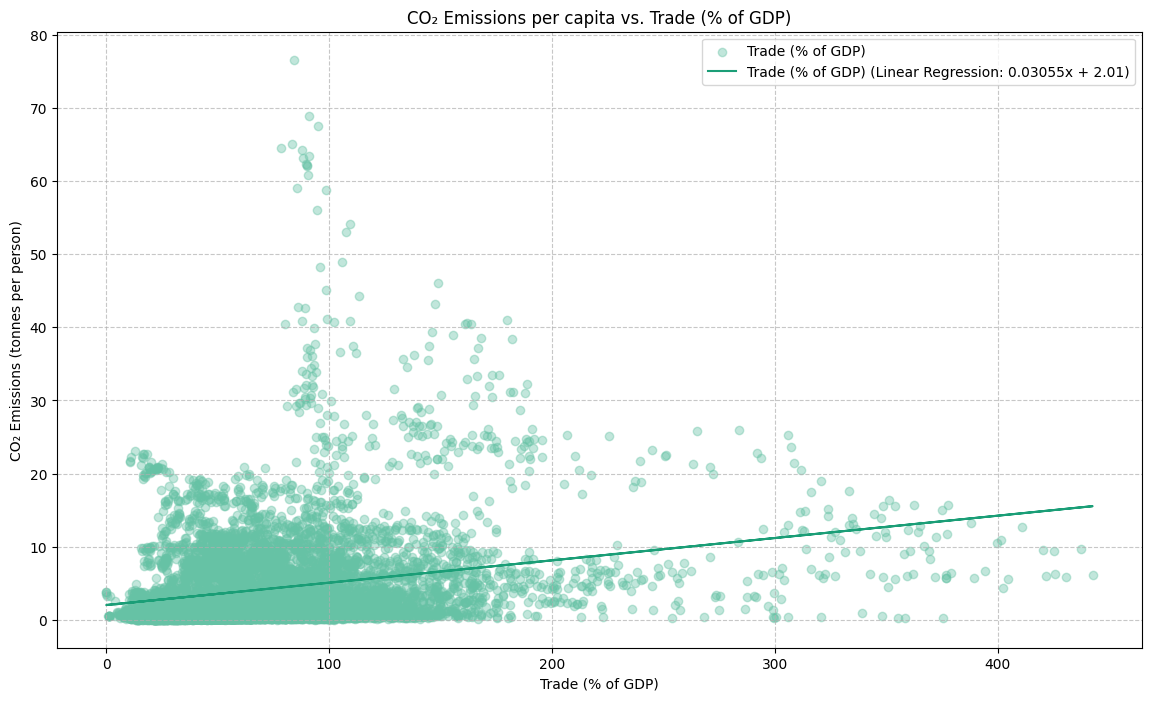

In [ ]:
# Create scatterplot with regression line
make_scatterplot(df_trade, ['Trade (% of GDP)'],
                 ['CO2 Emissions'],
                 xlabel="Trade (% of GDP)",
                 ylabel="CO₂ Emissions (tonnes per person)",
                 title="CO₂ Emissions per capita vs. Trade (% of GDP)",
                 decimals=0)

In [ ]:
# Calculate correlation
calc_correlation(df_trade, 'Trade (% of GDP)', 'CO2 Emissions')

Correlation between Trade (% of GDP) and CO2 Emissions :
Correlation with pearsonr =  0.24685378432688546  with a p-value of  3.6510970315568383e-116
Correlation with corr method =  0.24685378432688487 



The graph shows that the Trade Openness Index has a small influence on the CO₂ emission per capita of a country. When the share of the GDP used in trading raises with 1%, the CO₂ emission of that country in that year raises with 0.03 tonnes per capita of a country on average.
The correlation shows a weak significant correlation of 0.21.

# Factor 6: Deforestation
To research the influence of deforestation on CO₂ emissions, two datasets are used. The first dataset that is used shows the annual deforestation in hectares per year for each country.
The second dataset used shows the percentage of forest area of a country for a given year.
The definition of forest area for this dataset:
> "Forest area is land with natural or planted stands of trees at least five meters in height, whether productive or not, and excludes tree stands in
agricultural production systems."

*(UN Food and Agriculture Organization (FAO). Forest Resources Assessment via [Our World in Data](https://ourworldindata.org/grapher/annual-deforestation); Food and Agriculture Organization of the United Nations and historical sources via [Our World in Data](https://ourworldindata.org/grapher/forest-area-as-share-of-land-area))*


In [ ]:
deforest = pd.read_csv('https://raw.githubusercontent.com/Evely90/Co2-Emissions/main/annual-deforestation.csv')

# Drop unneccessary column
deforest = deforest.drop(columns=['Code'])

# Rename columns
deforest = deforest.rename(columns={"Entity": "Country"})

# Merge dataframes
df_deforest = pd.merge(df, deforest, on=["Country", "Year"])
df_deforest
# ! The dataset is rather small so conclusions need to be made with caution

,Country,Year,CO2 Emissions,Deforestation
0,Algeria,1990,3.007187,14800.0
1,Algeria,2000,2.774968,14500.0
2,Algeria,2010,3.300762,1400.0
3,Algeria,2015,4.048425,5400.0
4,Argentina,1990,3.434042,213600.0
...,...,...,...,...
418,Zambia,2015,0.311725,189710.0
419,Zimbabwe,1990,1.537646,46070.0
420,Zimbabwe,2000,1.167603,46070.0
421,Zimbabwe,2010,0.681789,46070.0


In [ ]:
# Check for null values
df_deforest.isnull().sum()

Country          0
Year             0
CO2 Emissions    0
Deforestation    0
dtype: int64

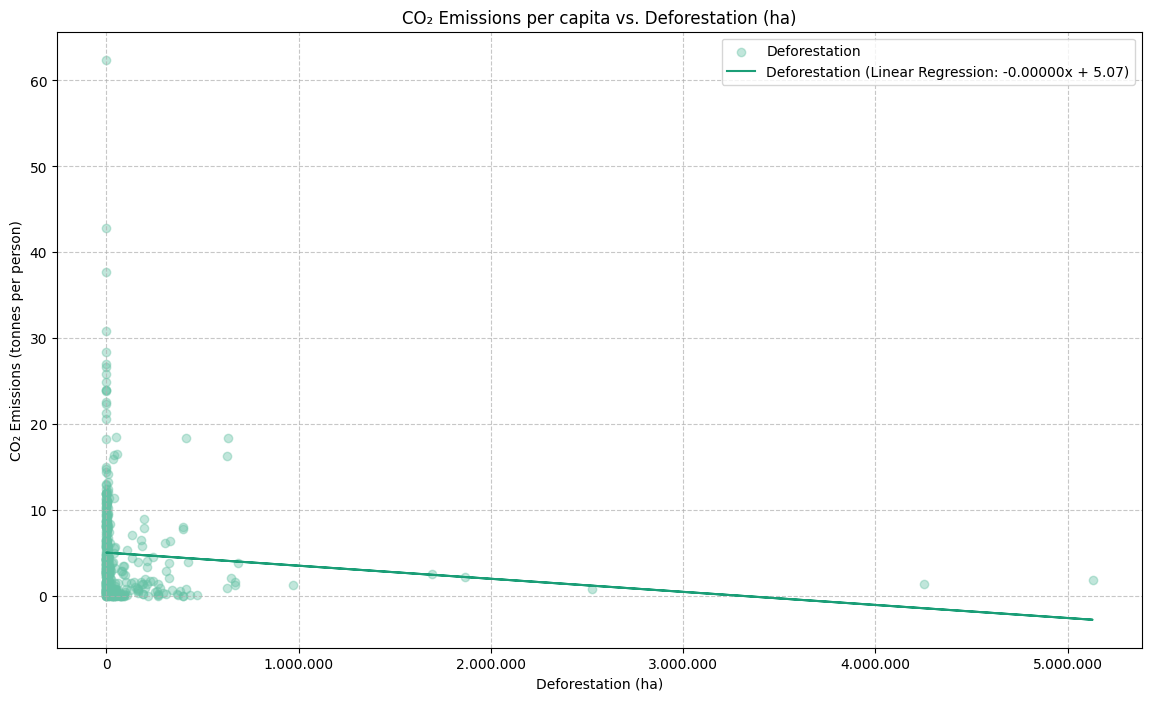

In [ ]:
# Create scatterplot with regression line
make_scatterplot(df_deforest, ['Deforestation'],
                 ['CO2 Emissions'],
                 xlabel="Deforestation (ha)",
                 ylabel="CO₂ Emissions (tonnes per person)",
                 title="CO₂ Emissions per capita vs. Deforestation (ha)",
                 decimals=0)

In [ ]:
# Calculate correlation
calc_correlation(df_deforest, 'Deforestation', 'CO2 Emissions')

Correlation between Deforestation and CO2 Emissions :
Correlation with pearsonr =  -0.0885990816217458  with a p-value of  0.06869760328456936
Correlation with corr method =  -0.08859908162174591 



In [ ]:
forest_area = pd.read_csv('https://raw.githubusercontent.com/Evely90/Co2-Emissions/main/forest-area-as-share-of-land-area.csv')

# Drop unneccessary column
forest_area = forest_area.drop(columns=['Code'])

# Rename columns
forest_area = forest_area.rename(columns={"Entity": "Country"})

# Merge dataframes
df_forest_area = pd.merge(df, forest_area, on=["Country", "Year"])
df_forest_area
# ! This dataset is a lot bigger than the deforestation dataset so probably more useful

,Country,Year,CO2 Emissions,Forest cover
0,Afghanistan,1990,0.189281,1.850994
1,Afghanistan,1991,0.178155,1.850994
2,Afghanistan,1992,0.122916,1.850994
3,Afghanistan,1993,0.106182,1.850994
4,Afghanistan,1994,0.094065,1.850994
...,...,...,...,...
6233,Zimbabwe,2016,0.728822,45.570273
6234,Zimbabwe,2017,0.630165,45.451183
6235,Zimbabwe,2018,0.711830,45.332093
6236,Zimbabwe,2019,0.636645,45.213002


In [ ]:
# Check for null values
df_forest_area.isnull().sum()

Country          0
Year             0
CO2 Emissions    0
Forest cover     0
dtype: int64

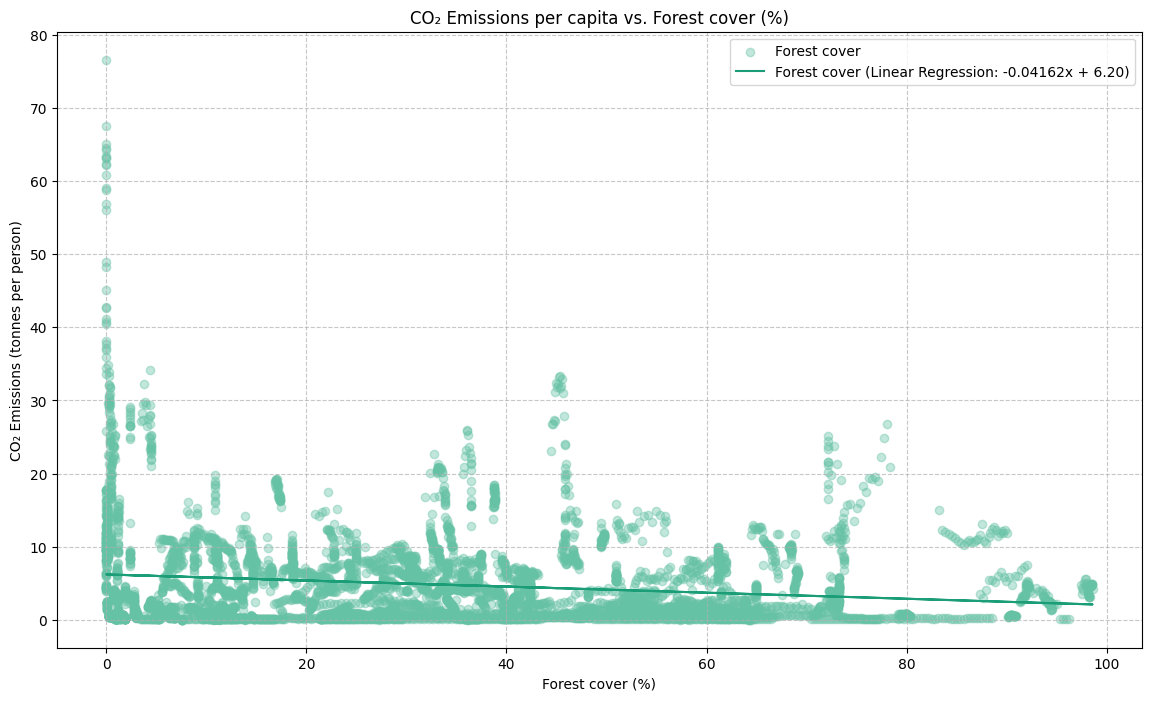

In [ ]:
# Create scatterplot with regression line
make_scatterplot(df_forest_area, ['Forest cover'],
                 ['CO2 Emissions'],
                 xlabel="Forest cover (%)",
                 ylabel="CO₂ Emissions (tonnes per person)",
                 title="CO₂ Emissions per capita vs. Forest cover (%)",
                 decimals=0)

In [ ]:
# Calculate correlation
calc_correlation(df_forest_area, 'Forest cover', 'CO2 Emissions')

Correlation between Forest cover and CO2 Emissions :
Correlation with pearsonr =  -0.15876871760078404  with a p-value of  1.695193798913045e-36
Correlation with corr method =  -0.1587687176007846 



For both graphs, there is a very small (negative) correlation so no conclusions can be drawn about the relation between amount of forest/deforestation and CO₂ emissions. This could be due to some countries having high CO₂ emissions per head of capita, such as Kuwait, Qatar and United Arab Emirates, don't have any forest cover so there is no deforestation in these countries.

The Forest cover graph shows that for each percentage of extra forest cover in a country, the CO₂ Emission per head of capita decreases with 0.04 tonnes. This possible relationship is however not strongly significantly correlated.

# Factor 7: Oil production
For this factor, a dataset is used that shows the amount of oil production of a country for certain years in Terawatt Hours (TWh).

 *(Energy Institute - Statistical Review of World Energy (2023); The Shift Data Portal (2019)  via [Our World in Data](https://ourworldindata.org/grapher/oil-production-by-country))*.

In [ ]:
oil = pd.read_csv('https://raw.githubusercontent.com/Evely90/Co2-Emissions/main/oil-production-by-country.csv')

# Drop unneccessary column
oil = oil.drop(columns=['Code'])

# Rename columns
oil = oil.rename(columns={"Entity": "Country"})

# Merge dataframes
df_oil = pd.merge(df, oil, on=["Country", "Year"])
df_oil

,Country,Year,CO2 Emissions,Oil production (TWh)
0,Afghanistan,1980,0.140654,0.0
1,Afghanistan,1981,0.177358,0.0
2,Afghanistan,1982,0.207625,0.0
3,Afghanistan,1983,0.253225,0.0
4,Afghanistan,1984,0.275442,0.0
...,...,...,...,...
11753,Zimbabwe,2012,0.848359,0.0
11754,Zimbabwe,2013,0.861012,0.0
11755,Zimbabwe,2014,0.862179,0.0
11756,Zimbabwe,2015,0.865772,0.0


In [ ]:
# Check for null values
df_oil.isnull().sum()

Country                 0
Year                    0
CO2 Emissions           0
Oil production (TWh)    0
dtype: int64

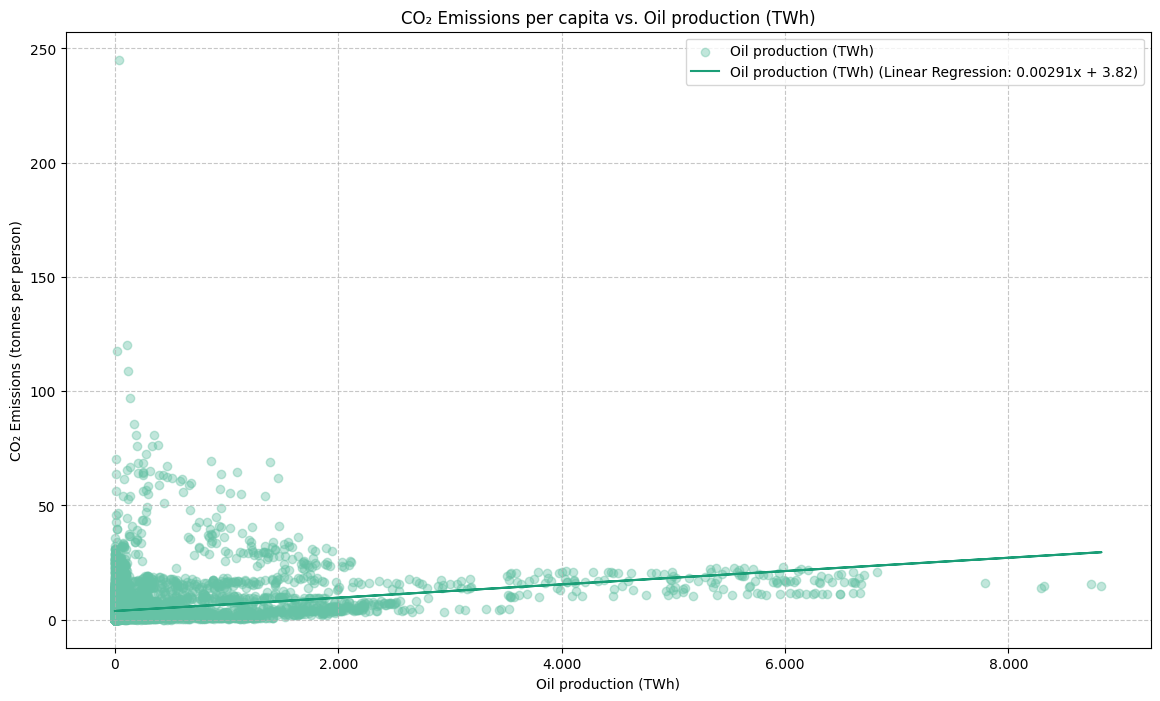

In [ ]:
# Create scatterplot with regression line
make_scatterplot(df_oil, ['Oil production (TWh)'],
                 ['CO2 Emissions'],
                 xlabel="Oil production (TWh)",
                 ylabel="CO₂ Emissions (tonnes per person)",
                 title="CO₂ Emissions per capita vs. Oil production (TWh)",
                 decimals=0)

In [ ]:
# Calculate correlation
calc_correlation(df_oil, 'Oil production (TWh)', 'CO2 Emissions')

Correlation between Oil production (TWh) and CO2 Emissions :
Correlation with pearsonr =  0.2773423702839926  with a p-value of  1.2692191876377923e-206
Correlation with corr method =  0.27734237028399245 



The graph shows the influence of the amount of oil production of a country on the CO₂ emission per head of capita is negligible. For each 100 TWh of oil production of a country, the CO₂ emissions raises with 0.29 tonnes per person. The correlation between these factors is weak with 0.28.

# Factor 8: Aviation

For this factor, a dataset is used that shows the amount of passengers carried on airlines registered in each country. Passengers are counted each time they travel *(International Civil Aviation Organization (via World Bank) via [Our World In Data](https://ourworldindata.org/grapher/air-passengers-carried))*.

In [ ]:
aviation = pd.read_csv('https://raw.githubusercontent.com/Evely90/Co2-Emissions/main/air-passengers-carried.csv')

# Drop unneccessary column
aviation = aviation.drop(columns=['Code'])

# Rename columns
aviation = aviation.rename(columns={"Entity": "Country", "Air transport, passengers carried": "Passengers"})

# Merge dataframes
df_aviation = pd.merge(df, aviation, on=["Country", "Year"])
df_aviation

,Country,Year,CO2 Emissions,Passengers
0,Afghanistan,1970,0.155343,84700.00
1,Afghanistan,1971,0.171894,97400.00
2,Afghanistan,1972,0.135588,104900.00
3,Afghanistan,1973,0.141288,96600.00
4,Afghanistan,1974,0.161177,96100.00
...,...,...,...,...
7396,Zimbabwe,2015,0.865772,370165.00
7397,Zimbabwe,2016,0.728822,378803.00
7398,Zimbabwe,2017,0.630165,282539.00
7399,Zimbabwe,2018,0.711830,282539.00


In [ ]:
# Check for null values
df_aviation.isnull().sum()

Country          0
Year             0
CO2 Emissions    0
Passengers       0
dtype: int64

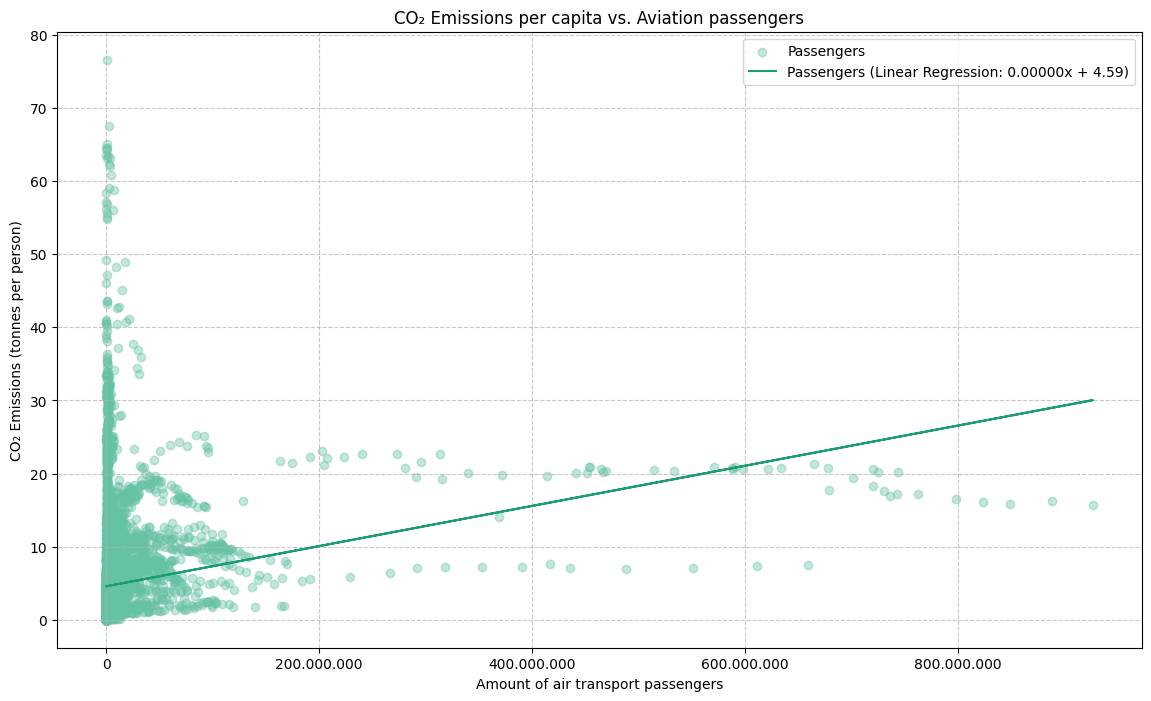

In [ ]:
# Create scatterplot with regression line
make_scatterplot(df_aviation, ['Passengers'],
                 ['CO2 Emissions'],
                 xlabel="Amount of air transport passengers",
                 ylabel="CO₂ Emissions (tonnes per person)",
                 title="CO₂ Emissions per capita vs. Aviation passengers",
                 decimals=0)

In [ ]:
# Calculate correlation
calc_correlation(df_aviation, 'Passengers', 'CO2 Emissions')

Correlation between Passengers and CO2 Emissions :
Correlation with pearsonr =  0.20443217343393263  with a p-value of  1.1617040149756621e-70
Correlation with corr method =  0.20443217343393238 



The correlation between amount of passengers carried on air transport for each country and the CO₂ emissions per head of capita is weak with 0.2. Therefore conclusions can't be drawn on the influence of aviation on CO₂ emissions. The graph shows that for every 100.000.000 passengers, the CO₂ emissions increases with around 2,5 tonnes per head of capita. So if there is any effect of aviation on CO₂ emissions per head of capita, the effect is negligible.

# Factor 9: Transport
For this factor, a dataset is used that shows the per capita CO₂ emissions from transport in tonnes per person. International aviation and shipping emissions are not included in this dataset.

*(Climate Watch (2023); Population based on various sources (2023) via [Our World In Data](https://ourworldindata.org/grapher/per-capita-co2-transport)
)*

In [ ]:
transport = pd.read_csv('https://raw.githubusercontent.com/Evely90/Co2-Emissions/main/per-capita-co2-transport.csv')

# Drop unneccessary column
transport = transport.drop(columns=['Code'])

# Rename columns
transport = transport.rename(columns={"Entity": "Country", "Per capita carbon dioxide emissions from transport": "Transport emissions"})

# Merge dataframes
df_transport = pd.merge(df, transport, on=["Country", "Year"])
transport

,Country,Year,Transport emissions
0,Afghanistan,1990,0.091633
1,Afghanistan,1991,0.086551
2,Afghanistan,1992,0.061373
3,Afghanistan,1993,0.052843
4,Afghanistan,1994,0.047232
...,...,...,...
6223,Zimbabwe,2016,0.148761
6224,Zimbabwe,2017,0.149819
6225,Zimbabwe,2018,0.188677
6226,Zimbabwe,2019,0.163469


In [ ]:
# Check for null values
df_transport.isnull().sum()

Country                0
Year                   0
CO2 Emissions          0
Transport emissions    0
dtype: int64

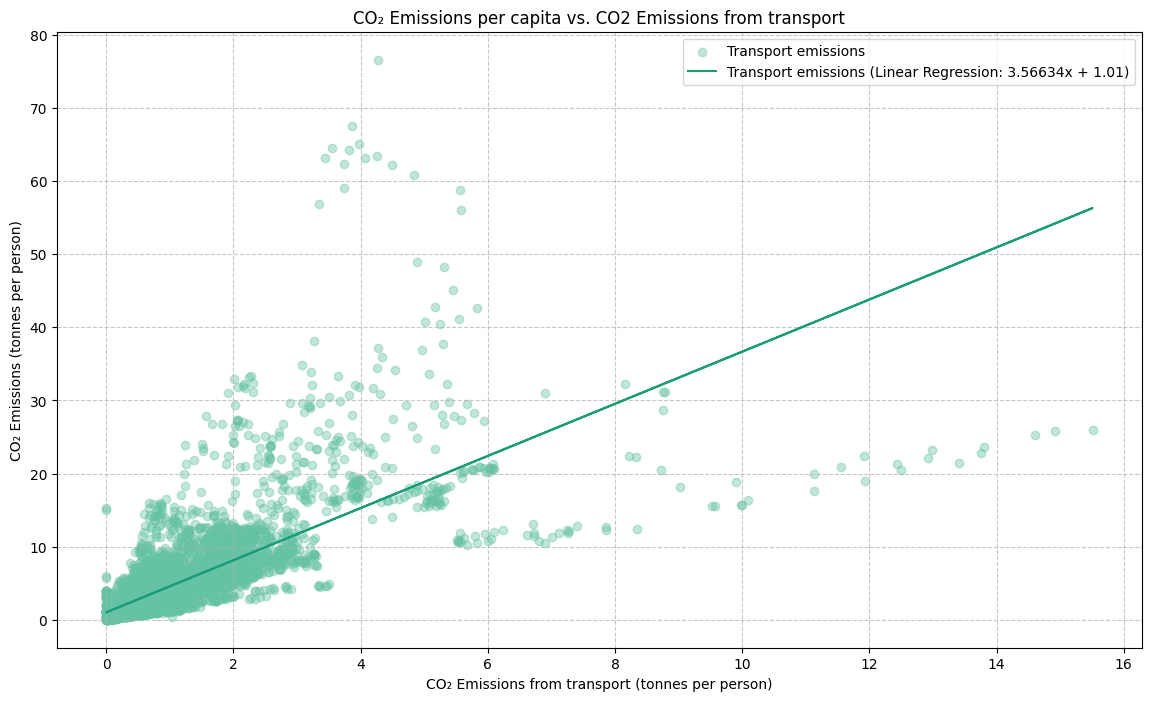

In [ ]:
# Create scatterplot with regression line
make_scatterplot(df_transport, ['Transport emissions'],
                 ['CO2 Emissions'],
                 xlabel="CO₂ Emissions from transport (tonnes per person)",
                 ylabel="CO₂ Emissions (tonnes per person)",
                 title="CO₂ Emissions per capita vs. CO2 Emissions from transport",
                 decimals=0)

In [ ]:
# Calculate correlation
calc_correlation(df_transport, 'Transport emissions', 'CO2 Emissions')

Correlation between Transport emissions and CO2 Emissions :
Correlation with pearsonr =  0.7256923876815456  with a p-value of  0.0
Correlation with corr method =  0.7256923876815459 



The correlation shows a strong positive correlation between CO₂ emissions per capita from transportation and overall CO₂ emissions per capita. Examining the graph, it shows that for every 1 ton of CO2 emissions per person from transport, there is an increase of 3.57 tonnes in overall CO₂ emissions per capita. It's important to note that each ton of CO₂ emissions from transport contributes directly to the total CO₂ emissions per capita. So when accounting for this, each ton of CO₂ emissions from transportation leads to an additional 2.57 tonnes of CO₂ emissions per capita. Therefore, transportation is a big predictor of CO₂ emissions of a country.

# Factor 10: Livestock
For this factor, 4 different datasets are used:
- The first one has the land area of all countries for different years in km² *(Food and Agriculture Organization of the United Nations (via World Bank) via [Our World in Data](https://ourworldindata.org/grapher/land-area-km)*.
- The second one has the number of cattle of a country for different years *(Food and Agriculture Organization of the United Nations via ([Our World in Data](https://ourworldindata.org/grapher/cattle-livestock-count-heads))*.
- The third one has the number of pigs of a country for different years *(Food and Agriculture Organization of the United Nations via ([Our World in Data](https://ourworldindata.org/grapher/pig-livestock-count-heads))*.
- The fourth one has the number of poultry of a country for different years *(Food and Agriculture Organization of the United Nations via ([Our World in Data](https://ourworldindata.org/grapher/poultry-livestock-count))*.

With these 4 datasets, a new dataset is created that shows the amount of cattle, pigs and poultry per km² in a country so a fair comparison can be made.


In [ ]:
landarea = pd.read_csv('https://raw.githubusercontent.com/Evely90/Co2-Emissions/main/land-area-km.csv')

# Drop unneccessary column
landarea = landarea.drop(columns=['Code'])

# Rename columns
landarea = landarea.rename(columns={"Entity": "Country"})

In [ ]:
cattle = pd.read_csv('https://raw.githubusercontent.com/Evely90/Co2-Emissions/main/cattle-livestock-count-heads.csv')

# Drop unneccessary column
cattle = cattle.drop(columns=['Code'])

# Rename columns
cattle = cattle.rename(columns={"Entity": "Country", "Cattle | 00000866 || Stocks | 005111 || animals": "Cattle"})

In [ ]:
pigs = pd.read_csv('https://raw.githubusercontent.com/Evely90/Co2-Emissions/main/pig-livestock-count-heads.csv')

# Drop unneccessary column
pigs = pigs.drop(columns=['Code'])

# Rename columns
pigs = pigs.rename(columns={"Entity": "Country", "Swine / pigs | 00001034 || Stocks | 005111 || animals": "Pigs"})

In [ ]:
poultry = pd.read_csv('https://raw.githubusercontent.com/Evely90/Co2-Emissions/main/poultry-livestock-count.csv')

# Drop unneccessary column
poultry = poultry.drop(columns=['Code'])

# Rename columns
poultry = poultry.rename(columns={"Entity": "Country", "Poultry | 00002029 || Stocks | 005112 || animals": "Poultry"})

In [ ]:
# Merge dataframes
df_merged = pd.merge(landarea, cattle, on=["Country", "Year"])
df_merged = pd.merge(df_merged, pigs, on=["Country", "Year"])
df_livestock = pd.merge(df_merged, poultry, on=["Country", "Year"])

In [ ]:
# Create new columns with cattle/pigs/poultry per km2
df_livestock['Cattle per km²'] = df_livestock['Cattle'] / df_livestock['Land area (sq. km)']
df_livestock['Pigs per km²'] = df_livestock['Pigs'] / df_livestock['Land area (sq. km)']
df_livestock['Poultry per km²'] = df_livestock['Poultry'] / df_livestock['Land area (sq. km)']

# Drop some columns
df_livestock = df_livestock.drop(columns=['Cattle'])
df_livestock = df_livestock.drop(columns=['Pigs'])
df_livestock = df_livestock.drop(columns=['Poultry'])
df_livestock = df_livestock.drop(columns=['Land area (sq. km)'])
df_livestock

,Country,Year,Cattle per km²,Pigs per km²,Poultry per km²
0,Albania,1961,15.335766,4.759124,57.664234
1,Albania,1962,15.142336,4.675182,61.204380
2,Albania,1963,14.857664,3.941606,60.255474
3,Albania,1964,14.653285,4.069343,61.751825
4,Albania,1965,15.587591,5.350365,60.985401
...,...,...,...,...,...
9498,Zimbabwe,2016,14.290402,1.100013,38.676490
9499,Zimbabwe,2017,13.786592,0.625617,40.493731
9500,Zimbabwe,2018,13.743562,0.626183,42.318728
9501,Zimbabwe,2019,13.073706,0.472783,44.244539


In [ ]:
# Merge with CO2 emissions dataframe
df_livestock_co2 = pd.merge(df, df_livestock, on=["Country", "Year"])
df_livestock_co2

,Country,Year,CO2 Emissions,Cattle per km²,Pigs per km²,Poultry per km²
0,Albania,1961,1.287979,15.335766,4.759124,57.664234
1,Albania,1962,1.346509,15.142336,4.675182,61.204380
2,Albania,1963,1.101846,14.857664,3.941606,60.255474
3,Albania,1964,1.033696,14.653285,4.069343,61.751825
4,Albania,1965,1.080787,15.587591,5.350365,60.985401
...,...,...,...,...,...,...
8951,Zimbabwe,2016,0.728822,14.290402,1.100013,38.676490
8952,Zimbabwe,2017,0.630165,13.786592,0.625617,40.493731
8953,Zimbabwe,2018,0.711830,13.743562,0.626183,42.318728
8954,Zimbabwe,2019,0.636645,13.073706,0.472783,44.244539


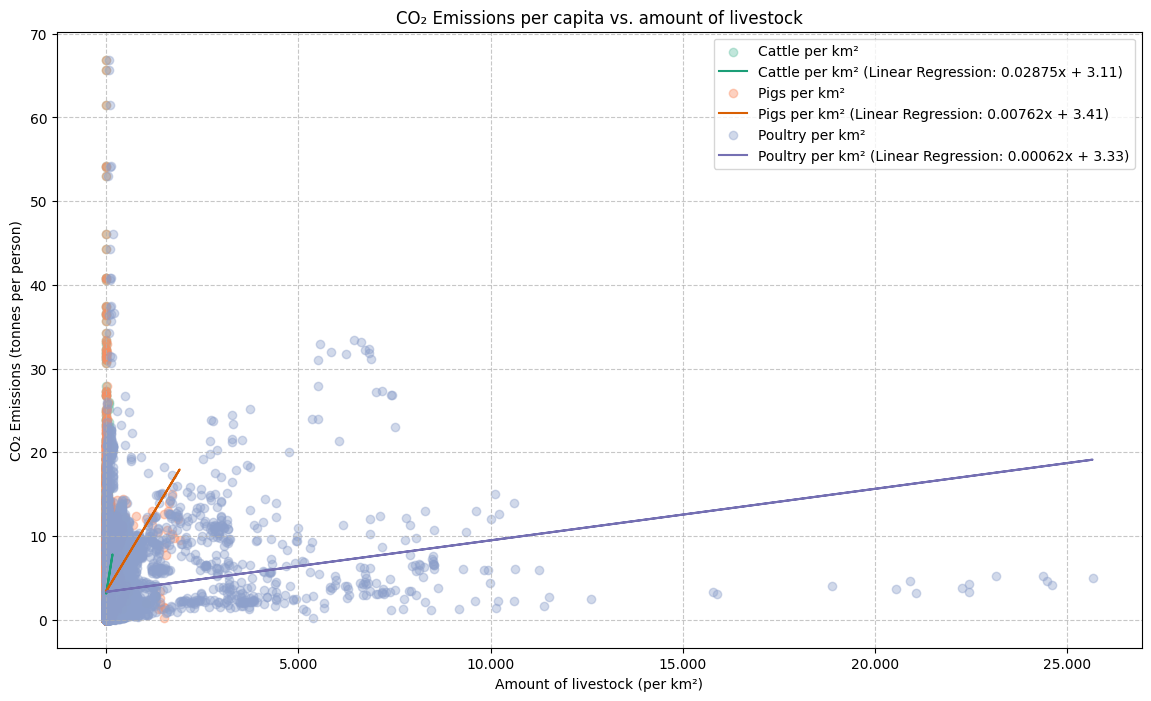

In [ ]:
# Create scatterplot with regression line
make_scatterplot(df_livestock_co2, ['Cattle per km²', 'Pigs per km²', 'Poultry per km²'],
                 ['CO2 Emissions'],
                 xlabel="Amount of livestock (per km²)",
                 ylabel="CO₂ Emissions (tonnes per person)",
                 title="CO₂ Emissions per capita vs. amount of livestock",
                 decimals=0)

In [ ]:
# Calculate correlation
calc_correlation(df_livestock_co2, 'Cattle per km²', 'CO2 Emissions')
calc_correlation(df_livestock_co2, 'Pigs per km²', 'CO2 Emissions')
calc_correlation(df_livestock_co2, 'Poultry per km²', 'CO2 Emissions')

Correlation between Cattle per km² and CO2 Emissions :
Correlation with pearsonr =  0.11311839123802943  with a p-value of  6.743639213342558e-27
Correlation with corr method =  0.11311839123802919 

Correlation between Pigs per km² and CO2 Emissions :
Correlation with pearsonr =  0.14533974187135992  with a p-value of  1.7776914763824297e-43
Correlation with corr method =  0.1453397418713597 

Correlation between Poultry per km² and CO2 Emissions :
Correlation with pearsonr =  0.1711719705556217  with a p-value of  7.428239332999273e-60
Correlation with corr method =  0.17117197055562253 



The correlation between the different forms of livestock per square kilometer in a country and CO₂ emissions per head of capita is very weak. The linear regression analysis indicates the following:
- For every additional 100 cattle per square kilometer, CO₂ emissions per head of capita increases with 2.8 tonnes
- For every additional 100 pigs per square kilometer, CO₂ emissions per head of capita increases with 0.76 tonnes.
- For every additional 100 poultry per square kilometer, CO₂ emissions per head of capita increases with 0.062 tonnes.

Of all forms of livestock, the amount of cattle makes the CO₂ per head of capita of a country raise the most and the amount of poultry the least. However, since the correlation is weak, the amount of livestock is not a big predictor of CO₂ output.

# Conclusion

**What is the biggest predictor of a large CO₂ output per capita of a country?**

Out of the 10 different possible predictors researched, the following 3 predictors are the biggest:
- **GDP per capita**: with a correlation of 0.7 the GDP per capita causes an increase of 2.3 tonnes per head of capita for each $10.000 raise in GDP per capita.
- **Transport**: There is a strong positive correlation of 0.7 between transportation and CO₂ emissions per head of capita. Every ton of CO₂ emissions from transport leads to 2.57 extra tonnes of CO₂ emissions per capita.
- **HCI**: With a correlation of 0.5, the HCI could be a big predictor of CO₂ output, with the CO₂ emission per capita raising with 2.1 tonnes when the HCI raises with 0.1. However, this is only supported by a small amount of data.

There could however be additional big predictors of CO₂ output that have not been explored in this report.